<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Inverse Distance Estimation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of  **Inverse Distance Estimation**, a very simple, intuitive and widely applied spatial estimation method. 

**YouTube Lecture**: check out my lectures on:

* [Trend Modeling](https://www.youtube.com/watch?v=BCnivpSKF18&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=41)
* [Kriging](https://youtu.be/CVkmuwF8cJ8?si=TzwmoF7QtppoITOv)

For convenience here's a summary of spatial estimation and inverse distance estimation.

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
$$

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
$$

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

$$
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
$$

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

$$
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
$$

while satisfying the unbiasedness constraint.  

#### Inverse Distance Spatial Estimation

Now the next question is what weights should we use?  

We could use inverse distance weighting, 

$$
\lambda_{\alpha} = \frac{1}{(d_{\bf{u }_0,\bf{u }_{\alpha}})^p} 
$$

$\forall \alpha = 1,\ldots,n$, where $\bf{u }_{\alpha}$ is the data locations, $\bf{u }_0$ is the unknown location and there are $n$ local data available to support the estimate. $p$ is the power exponent. 

* larger $p$ will increase sensitivity to distance resulting a more specific, rougher model, with higher variance
* smaller $p$ will decrease sensitivity to distance resulting in a more general, smoother model, with lower variance.

Note, this is weighting based on closeness to the unknown location, there is not integration of redundancy between data nor the variogram model.

In this workflow we will start with some very simple, 3 data only, cases to observe inverse distance and then build a map with more data.

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting major and minor grid axes.

In [3]:
def add_grid():                                          
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   


#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [4]:
#os.chdir("d:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # load the data from Dr. Pyrcz's GitHub repository
df = df[['X','Y','Porosity']]                                 # remove the unneeded features, columns
df.head()                                                     # we could also use this command for a table preview 

,X,Y,Porosity
0,100.0,900.0,0.101319
1,100.0,800.0,0.147676
2,100.0,700.0,0.145912
3,100.0,600.0,0.186167
4,100.0,500.0,0.146088


#### Simple Test at Single Location

Let's test the method for a single estimation location.

* the result was validated with by-hand calculation for inside range, outside range and collocated with a data point

In [6]:
%%capture --no-display                                                                

x = [100,600,800,200]; y = [100,500,700,800]; vr = [1.0,2.0,3.0,4.0]      # 3 data test dataset
dftest = pd.DataFrame({'X':x,'Y':y,'Var':vr})
tmin = -9999.9; tmax = 9999.9;                                # data trimming limits
nx = 1; xsiz = 10.0; xmn = 500                                # test grid specification, single node
ny = 1; ysiz = 10.0; ymn = 500

ndmin = 1; ndmax = 100                                        # min and max number of data
radius = 1000.0; power = 2                                    # inverse distance parameters

invdist_est = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)
print('The single estimate at x = ' + str(xmn) + ', y = ' + str(ymn) + ' is ' + str(invdist_est[0][0]) + '.')

#### Build a Estimation Map

Now we check the method by building maps with 3 different powers.

* First we specify a grid and then rerun inverse distance for each map.

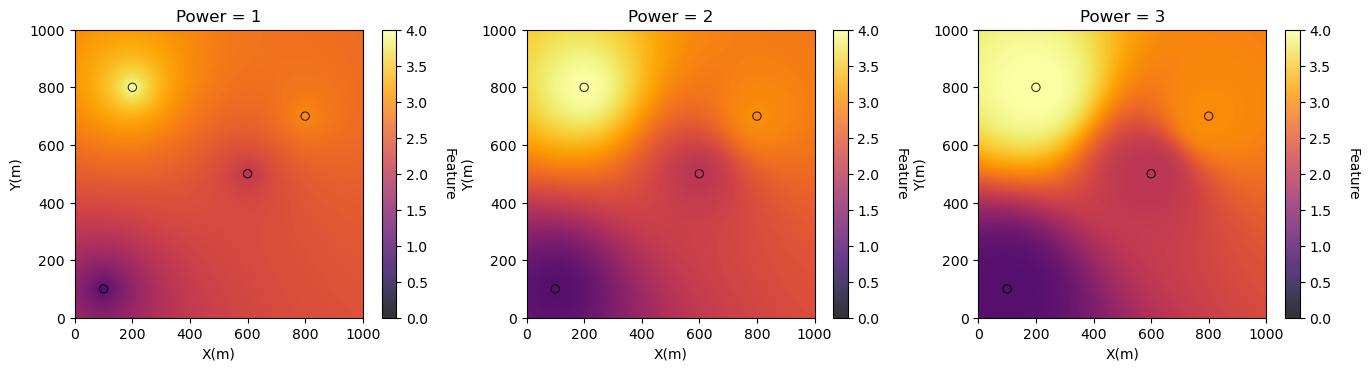

In [7]:
%%capture --no-display                                                                

nx = 100; xsiz = 10.0; xmn = 5.0; xmin = xmn - 0.5 * xsiz; xmax = xmin + nx * xsiz # test grid specification
ny = 100; ysiz = 10.0; ymn = 5.0; ymin = ymn - 0.5 * ysiz; ymax = ymin + ny * ysiz

radius = 10000.0                                              # inverse distance parameter

invdist_map_power1 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=1)
invdist_map_power2 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=2)
invdist_map_power3 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power=3)

# plot the resulting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_power1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Power = 1','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_power2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Power = 2','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_power3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Power = 3','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2) 
plt.show()

#### Check the Impact of Radius

Radius is the maximum distance to look for neighbouring data

* limited radius may result is image artifacts as data abruptly are excluded

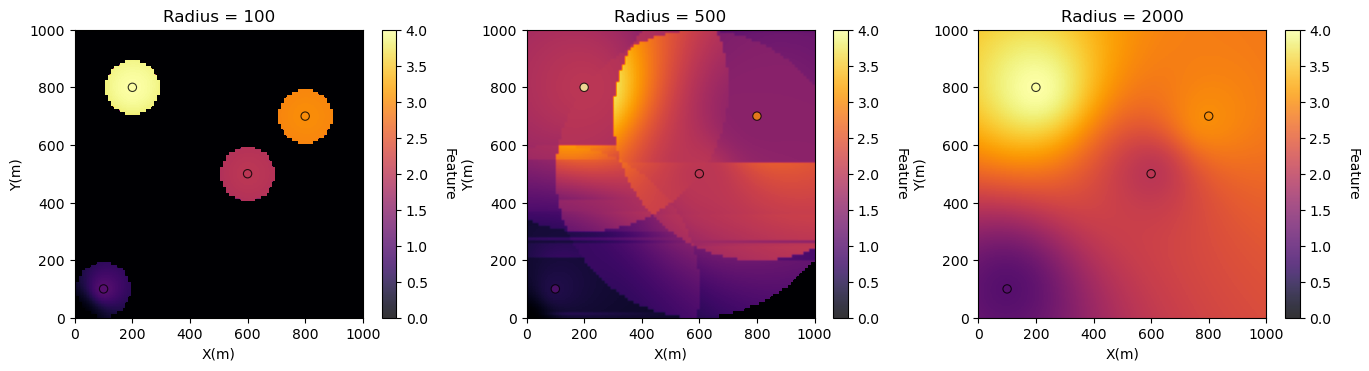

In [8]:
%%capture --no-display                                                                

power = 2

invdist_map_radius1 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 100,power=2)
invdist_map_radius2 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 500,power=2)
invdist_map_radius3 = geostats.invdist(dftest,'X','Y','Var',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius = 2000,power=2)

# plot the resulting estimated maps
plt.subplot(131)
GSLIB.locpix_st(invdist_map_radius1,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Radius = 100','X(m)','Y(m)','Feature',cmap)

plt.subplot(132)
GSLIB.locpix_st(invdist_map_radius2,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Radius = 500','X(m)','Y(m)','Feature',cmap)

plt.subplot(133)
GSLIB.locpix_st(invdist_map_radius3,xmin,xmax,ymin,ymax,xsiz,0.0,4.0,dftest,'X','Y','Var','Radius = 2000','X(m)','Y(m)','Feature',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.6, wspace=0.2, hspace=0.2) 
plt.show()

#### Inverse Distance Porosity Map

Now we are ready to build a map of our porosity spatial feature.

* let's use the full dataset now.

We use GeostatsPy's location map function.

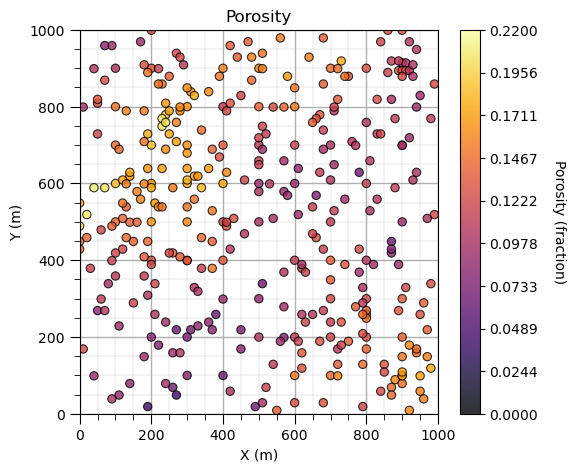

In [9]:
pormin = 0.0; pormax = 0.22

plt.subplot(111)                                              # location map
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,
                'Porosity','X (m)','Y (m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.8, wspace=0.5, hspace=0.3); add_grid(); plt.show()

#### Inverse Distance Map

Vary the radius and power below and build the inverse distance porosity map.

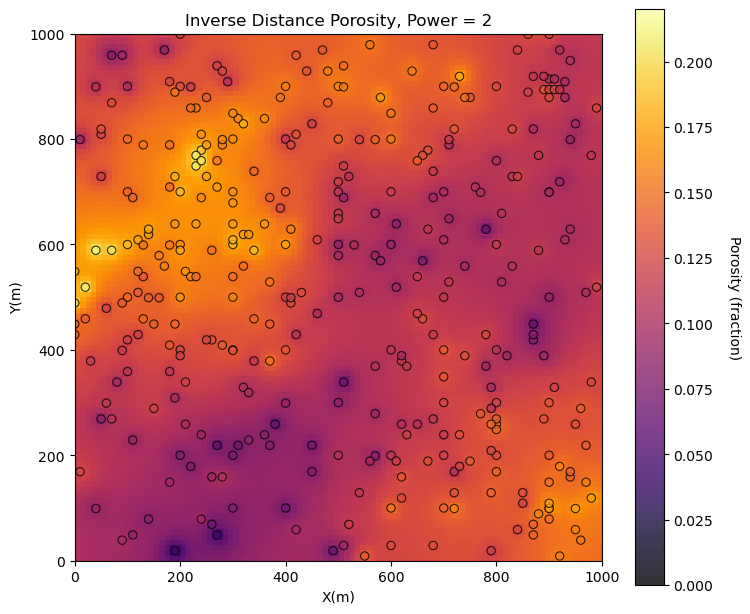

In [10]:
%%capture --no-display                                                                

radius = 2000; power = 2                                      # radius and power for inverse distance

invdist_map_porosity = geostats.invdist(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,power)

plt.subplot(131)                                     # plot the resulting estimated maps
GSLIB.locpix_st(invdist_map_porosity,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity',
        'Inverse Distance Porosity, Power = ' + str(power),'X(m)','Y(m)','Porosity (fraction)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of inverse distance maps with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)